In [1]:
#matplotlib widget
import numpy as np 
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt
import os
import sys
import importlib



sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/miniSpect')
sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/camera')
import Camera_util
import MS_util

In [2]:
# Define macro information about where to find the directories/files for all of the data
path_to_ssd: str = '/Volumes/EXTERNAL1'         
experiment_name: str = 'cpuPriority_5hz_0NDF'
frequency: float = 5
NDF: int = 0

In [3]:
# Define paths to individual sensor readings
#world_cam_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_world')
world_cam_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_world')
pupil_cam_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_pupil')
sunglasses_file: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_sunglasses.txt')
MS_readings_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_MS_readings')
frame_capture_time_file: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_world_frameTimings.csv')
#CPU_info_file: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_world_cpuInfo.csv')

#frame_capture_time_file: str = '/Volumes/EXTERNAL1/test_cam_only_5mins/test_cam_only_5mins_frameTimings.csv'


#assert(all(os.path.exists(path) == True for path in [world_cam_dir, pupil_cam_dir, MS_readings_dir, sunglasses_file]))

In [ ]:
frame_timings_df = Camera_util.parse_frame_capture_file(frame_capture_time_file)

In [ ]:
print(plt.hist(frame_timings_df['End'].to_numpy() - frame_timings_df['Begin'].to_numpy()))

frame_delta = frame_timings_df['End'].to_numpy() - frame_timings_df['Begin'].to_numpy()

In [ ]:
t = Camera_util.generate_temporal_support(frame_delta)

plt.plot(t, frame_delta, '-x')
plt.xlabel('Time [seconds]')

#plt.ylim([0, 0.03])
#plt.xlim([200.9,201.5])


In [ ]:
np.diff([1729866626.117364, 1729866626.126827, 1729866626.130503, 1729866626.138042, 1729866626.139749, 1729866626.150218, 1729866626.152386, 1729866626.158963, 1729866626.162154, 1729866626.167957])

In [ ]:
plt.plot(frame_timings_df['Begin'])

plt.show()

In [33]:
# Examine the world cam data 
sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/camera') # append the path to the camera libraries so we can use their files
import recorder     
import Camera_util

importlib.reload(Camera_util)

path_to_analyze = pupil_cam_dir


# Define the chunksize of time to analyze at a given time 
chunk_seconds: int = 60 # Look at one minute chunks

# Load in the paths to the 1-second buffer files 
buffer_files: list = [os.path.join(path_to_analyze, file) 
                     for file in natsorted(os.listdir(path_to_analyze))]

# Define the chunks 
chunks: list = [buffer_files[i:i+chunk_seconds] 
               for i in range(0, len(buffer_files), chunk_seconds)]

# Initialize a container for the fit info for each chunk 
r2_values: list = []
amplitudes: list = []
phases: list = []
fpss: list = []

# Retrieve a list of the fi%matplotlib widgetts of the observed modulations
fits: list = []

# FPS GUESS 
fps_guess: float = 119.8822

# Generate temporal support for the entire video
t: np.ndarray = Camera_util.generate_temporal_support(np.arange(0, chunk_seconds*120*len(chunks), 1/120), fps_guess)

# Iterate over the chunks
for chunk_idx, chunk in enumerate(chunks):
    # Skip initialization period
    if(chunk_idx < 2):
        continue

    print(f'Analyzing chunk {chunk_idx+1}/{len(chunks)} with size: {len(chunk)} buffers/seconds...')

    # Load in the frames from this chunk and generate temporal support for it
    chunk_frames: np.ndarray = Camera_util.parse_mean_frame_array_buffer(chunk)

    # Skip malformed chunks (like at the end when it isn't a minute long)
    if(chunk_frames.shape[0] != 120 * 60):
        continue

    start = chunk_idx * (60*120)
    end = start + 60*120 

    chunk_t: np.ndarray = t[start:end ]


    assert(chunk_frames.shape[0] == chunk_t.shape[0])

    # Fit the modulation for this chunk (Without interpolation)
    print('BEFORE INTERPOLATION')
    ret_info: tuple = Camera_util.fit_source_modulation_with_t(chunk_frames, chunk_t, frequency, 120.0)

    # Retrieve the amplitude and phase for the fit 
    amplitude, phase, observed_fps = ret_info[:3]

    # Retrieve the R2 from the ret information
    r2: float = ret_info[-1][-1] 

    # Append the info to the running lists of info 
    r2_values.append(r2)
    amplitudes.append(amplitude)
    phases.append(phase)
    fits.append(ret_info[-1][:-2])

    # Show the fit
    #plt.show()

    # Close the figure
    #plt.close(fig)



Analyzing chunk 3/7 with size: 60 buffers/seconds...
BEFORE INTERPOLATION
R2: 0.9923786946398633
Amplitude: 48.950419829639856
Analyzing chunk 4/7 with size: 60 buffers/seconds...
BEFORE INTERPOLATION
R2: 0.9923603407864517
Amplitude: 48.908807848406745
Analyzing chunk 5/7 with size: 60 buffers/seconds...
BEFORE INTERPOLATION
R2: 0.99237513112789
Amplitude: 48.95569371579699
Analyzing chunk 6/7 with size: 60 buffers/seconds...
BEFORE INTERPOLATION
R2: 0.9924140459647263
Amplitude: 48.69923962469165
Analyzing chunk 7/7 with size: 27 buffers/seconds...


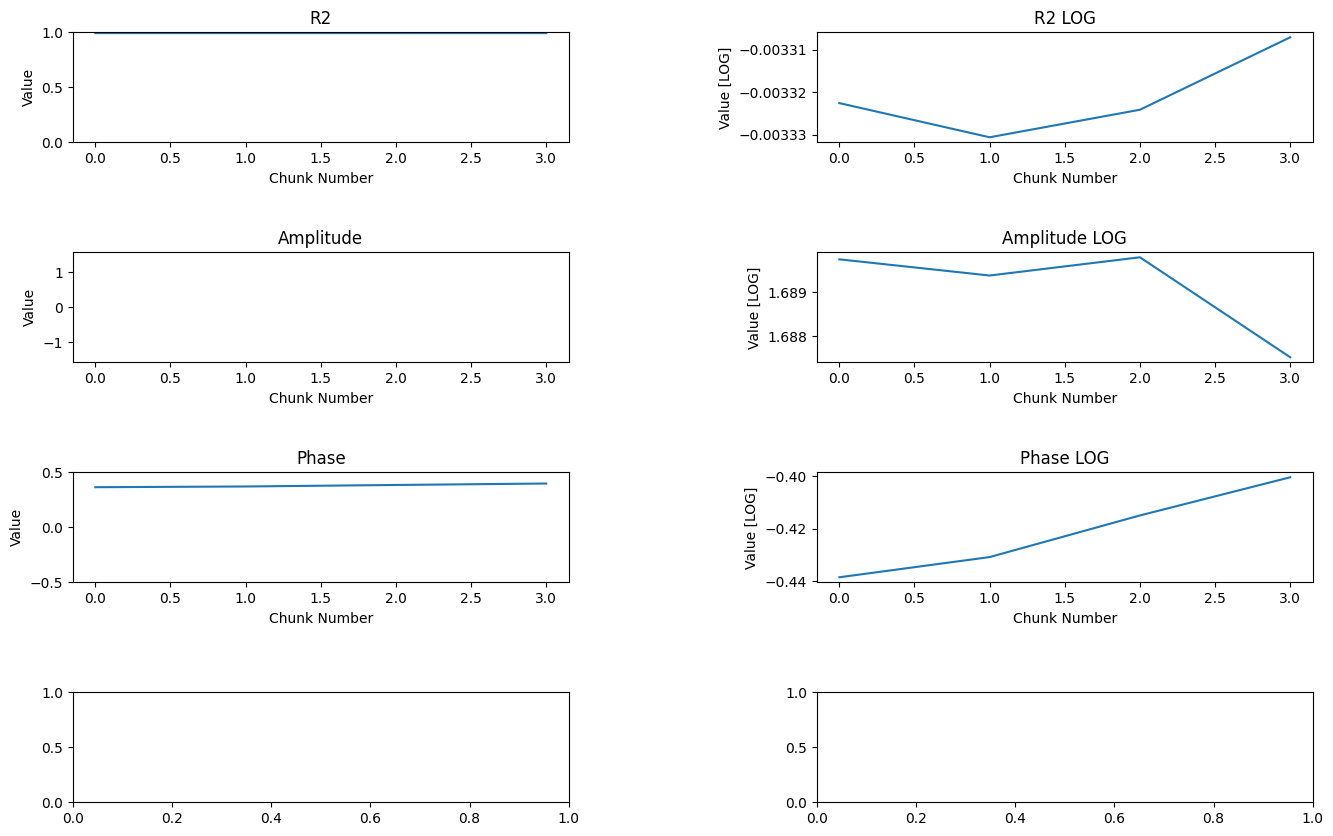

In [35]:
# Plot the R2, amplitudes, and phase by buffer 
# in both log and non-log scale
fig, axes = plt.subplots(4,2, figsize=(16,10))

# Keep track of what axis we are on 
ax_num: int = 0 

# r2 between 0 and 1 
# phase between -pi/2 and pi/2 

# amplitude between 0 and 0.5

# Iterate over the measurements with their associated axes and plot them
for i, (measurement, name, ylims, ax_row,) in enumerate(zip((r2_values, amplitudes, np.unwrap(phases, period=np.pi/2), fpss), ('R2', 'Amplitude', 'Phase', 'FPS'),([0,1.2],[-np.pi/2, np.pi/2], [-0.7,0.7]), axes)):
    # Retrieve the base 10 ax to plot on 
    # and the log ax 
    ax: plt.Axes = ax_row[0]
    log_ax: axes = ax_row[1]

    ax.ticklabel_format(style='plain', axis='y', useOffset=False)

    # Title the graphs
    ax.set_title(name)
    log_ax.set_title(f'{name} LOG')

    # Label the X axes 
    ax.set_xlabel('Chunk Number')
    log_ax.set_xlabel('Chunk Number')


    # Label the Y axes
    ax.set_ylabel('Value')
    ax.set_ylim(ylims)
    log_ax.set_ylabel('Value [LOG]')

    # Plot the data 
    ax.plot(measurement)
    log_ax.plot(np.log10(measurement))


    # Update the ax num
    ax_num += 2 
    
# Adjust the spacing in the plot
plt.subplots_adjust(wspace=0.5, hspace=1)

# Show the plot
plt.show()

In [ ]:
avg_r2_100, median_r2_100 = np.mean(r2_values), np.median(r2_values)

print(avg_r2_100)
print(median_r2_100)

In [ ]:
avg_r2_30, median_r2_30 = np.mean(r2_values), np.median(r2_values)

print(avg_r2_30)
print(median_r2_30)